# **Trotter Error Analysis Part 1**

This notebook computes and visualizes the error between exact and Trotterized time evolution for a three-qubit system.

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import scipy

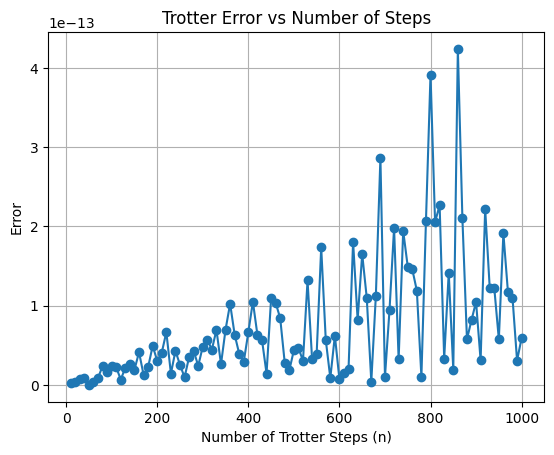

In [3]:
def error(N, t=10):
    Z = np.array([[1, 0], [0, -1]])
    I = np.identity(2)
    #Z1Z2 = np.tensordot(Z, Z, axes=0)
    Z1Z2 = np.kron(np.kron(I, Z), Z)
    Z2Z3 = np.kron(np.kron(Z, Z), I)

    H = Z1Z2 + Z2Z3
    # print(Z1Z2 - Z2Z3)

    time_evol_op = scipy.linalg.expm(-1j * t * H)

    U_Nt = np.identity(2**3, dtype=complex)

    for _ in range(N):
        U_Nt = np.matmul(U_Nt, scipy.linalg.expm(-1j * t/N * Z1Z2))
        U_Nt = np.matmul(U_Nt, scipy.linalg.expm(-1j * t/N * Z2Z3))

    # U_Nt = (scipy.linalg.expm(-1j * t/N * Z1Z2) * scipy.linalg.expm(-1j * t/N * Z2Z3))**N
    #U_Nt = scipy.sparse.linalg.matrix_power(scipy.linalg.expm(-1j * t/N * Z1Z2) * scipy.linalg.expm(-1j * t/N * Z2Z3), N)

    return scipy.linalg.norm(time_evol_op - U_Nt)

all = []
n_values = range(10, 1001, 10)

for n in n_values:
    all.append(error(n))

plt.plot(n_values, all, marker='o')
plt.xlabel('Number of Trotter Steps (n)')
plt.ylabel('Error')
#plt.xscale('log')
#plt.yscale('log')
plt.title('Trotter Error vs Number of Steps')
plt.grid()
plt.show()

*Bit of analysis*

Using the logic from TrotterError3.ipynb, the difference $\delta$ between the exact time evolution operator and the Trotterized operator is
\begin{equation*}
    \delta = \frac{t^2}{2}\left(Z_1Z_2 - Z_2Z_3\right) + O(t^3).
\end{equation*}

In this specific case, the difference $Z_1Z_2 - Z_2Z_3$ is the matrix
\begin{equation*}
    Z_1Z_2 - Z_2Z_3 = \begin{pmatrix}
        0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
        0 & -2 & 0 & 0 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 2 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & 2 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
        0 & 0 & 0 & 0 & 0 & 0 & -2 & 0 \\
        0 & 0 & 0 & 0 & 0 & 0 & 0 & 0
    \end{pmatrix}
\end{equation*}
which has norm zero, explaining the above graph, which is essentially zero (anything graphed is a result of floating point arithmetic errors).

There is a general upward trend, though, which we attribute the the accumulation of floating-point errors as time goes on. Sometimes the errors cancel out, but on average the error increases.